In [19]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from collections import OrderedDict

In [20]:
#results_directory = 'exp_results_wm/'
results_directory = 'exp_results_reward/'
# Load the results
# Folder structure "env_name/run-agent_name_seed**.csv"
# For each environment and agent load all corresponding csv

envs = os.listdir(results_directory)
max_steps = {
    'Corridor': 2000000,
    '5m_vs_6m': 2000000,
    'MMM2':2000000,
    '3s5z_vs_3s6z': 3000000,
    '27m_vs_30m': 2000000,
    '2c_vs_64zg': 2000000,
    '6h_vs_8z': 3000000,
    'protoss_5_vs_5': 2000000,
    'terran_5_vs_5':2000000,
    'zerg_5_vs_5':2000000,
    'protoss_10_vs_11':3000000,
    'terran_10_vs_11': 2500000,
    'zerg_10_vs_11': 3000000
}

results_envs = OrderedDict()
for env in envs:
    if env == '.DS_Store':
        continue
    results_envs[env] = OrderedDict()
    env_dir = os.path.join(results_directory, env)
    results = os.listdir(env_dir)
    
    for result in results:
        if result == '.DS_Store' or result == 'legacy':
            continue
        if result.split('-')[0]=='run':
            run_name = result.split('-')[1]
        else:
            run_name = result.split('-')[0]
        agent = run_name.split('_')[0]
        if agent=='ACORMWM':
            agent='R3DM'
        csv_results = pd.read_csv(results_directory + env + '/' + result)
        if agent not in results_envs[env]:    
            results_envs[env][agent] = [csv_results]
        else:
            results_envs[env][agent].append(csv_results)


In [21]:
def compute_statistics(data, every=None):

    left_bound = 0
    stats = {}
    sums = 0
    squared_sums = 0
    num_items = 0
    count = 0
    for row in data.values:
        step = row[0]
        count += 1
        if count - left_bound > every:
            left_bound += 1
            prev_vals = np.array(data.iloc[left_bound - 1, 1:])
            prev_vals = prev_vals[~np.isnan(prev_vals)]
            
            sums -= np.sum(prev_vals)
            squared_sums -= np.sum(prev_vals**2)
            num_items -= len(prev_vals)
        
        
        values = np.array(row[1:])
        values = values[~np.isnan(values)]
        print(values)
        sums += np.sum(values)
        squared_sums += np.sum(values**2)
        num_items += len(values)

        
        stats[step] = {'Step': step, 'Value': sums/num_items , 'std_dev': np.sqrt(squared_sums/num_items - (sums/num_items)**2)}


    
    # # Compute statistics for each bucket
    # stats = {}
    # for key, values in buckets.items():
    #     if values:  # Avoid empty lists
    #         mean_value = np.mean(values)
    #         variance_value = np.var(values)
    #         stats[key] = {'Step': key, 'Value': mean_value, 'std_dev': variance_value}

    return stats

In [22]:
# Average the 'value' column per timestep if there are multiple runs

averaged_results = OrderedDict()

for env in results_envs:
    averaged_results[env] = OrderedDict()
    for agent in results_envs[env]:
        results = results_envs[env][agent]
        if 'ACORM' in agent or 'QMIX' in agent or 'R3DM' in agent:
            # For each step average the all available values, ignore empty entries and dont fill
            print('Computing statistics for ' + env + ' ' + agent)
            stats = compute_statistics(results[0], every=25)
            window_size = 7
            avg_results = pd.DataFrame.from_dict(stats, orient='index')
            avg_results['Value'] = avg_results['Value'].rolling(window=window_size, min_periods=1, center=True).mean()
            avg_results['std_dev'] = avg_results['std_dev'].rolling(window=window_size, min_periods=1, center=True).mean()
            averaged_results[env][agent] = avg_results
                
        else:
            if len(results) > 1:
                # Average the 'value' column
                avg_results = results[0]
                
                for i in range(1, len(results)):
                    avg_results['Value'] += results[i]['Value']
                    avg_results['Step'] += results[i]['Step']
                avg_results['Value'] /= len(results)
                avg_results['Step'] /= len(results) 
                
                # Compute Standard Deviation
                std_dev = np.zeros(len(avg_results['Value']))
                for i in range(len(results)):
                    std_dev += (results[i]['Value'] - avg_results['Value'])**2
                std_dev = np.sqrt(std_dev/len(results))
                avg_results['std_dev'] = std_dev
                # Apply rolling window mean to smoothen results
                window_size = 7
                avg_results['Value'] = avg_results['Value'].rolling(window=window_size, min_periods=1, center=True).mean()
                avg_results['std_dev'] = avg_results['std_dev'].rolling(window=window_size, min_periods=1, center=True).mean()

                averaged_results[env][agent] = avg_results
                
            else:
                avg_results = results[0]
                # Compute Standard Deviation 
                std_dev = np.zeros(len(results[0]['Value']))
                avg_results['std_dev'] = std_dev
                averaged_results[env][agent] = avg_results

Computing statistics for zerg_5_vs_5 R3DM
[3.28427347 1.65641721 4.86836306]
[8.8403403 8.8403403 8.8403403]
[8.16368118 8.16368118 8.16368118]
[10.09343529 10.09343529 10.09343529]
[9.27395993 9.27395993 9.27395993]
[9.1508522 9.1508522 9.1508522]
[8.64743805 8.64743805 8.64743805]
[8.68322638 8.68322638 8.68322638]
[8.06645679 7.60241763 8.53049596]
[9.78366307 9.78366307 9.78366307]
[8.2787788 8.2787788 8.2787788]
[7.84320882 7.84320882 7.84320882]
[7.25323868 7.25323868 7.25323868]
[6.96468925 6.96468925 6.96468925]
[8.45620918 8.45620918 8.45620918]
[7.60447439 7.60447439 7.60447439]
[7.96254839 7.96254839 7.96254839]
[9.92911466 9.92911466 9.92911466]
[8.05464617 8.05464617 8.05464617]
[7.40962147 7.40962147 7.40962147]
[11.24795659 11.24795659 11.24795659]
[8.06748984 7.89618908 8.2387906 ]
[8.75261052 8.75261052 8.75261052]
[8.9569397 8.9569397 8.9569397]
[8.41699028 8.41699028 8.41699028]
[9.52892749 9.52892749 9.52892749]
[10.23124913 10.23124913 10.23124913]
[9.1873881 9.187

In [23]:
averaged_results

OrderedDict([('zerg_5_vs_5',
              OrderedDict([('GoMARL',
                                    Wall time       Step      Value   std_dev
                            0    1.736201e+09      253.8   5.990596  0.507252
                            1    1.736201e+09    10364.0   6.293544  0.460938
                            2    1.736201e+09    20440.4   6.464936  0.440533
                            3    1.736201e+09    30549.0   6.591723  0.451125
                            4    1.736202e+09    40648.2   7.211208  0.497527
                            ..            ...        ...        ...       ...
                            292  1.736289e+09  2957135.0  14.234061  0.892330
                            293  1.736289e+09  2967224.6  14.255219  0.977254
                            294  1.736289e+09  2977292.0  14.254962  1.047374
                            295  1.736289e+09  2987481.0  14.237531  1.030365
                            296  1.736289e+09  2997603.6  14.193432  1.1502

/tmp/ipykernel_4021548/3854603383.py:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, -1.70])
/tmp/ipykernel_4021548/3854603383.py:72: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, -1.70])


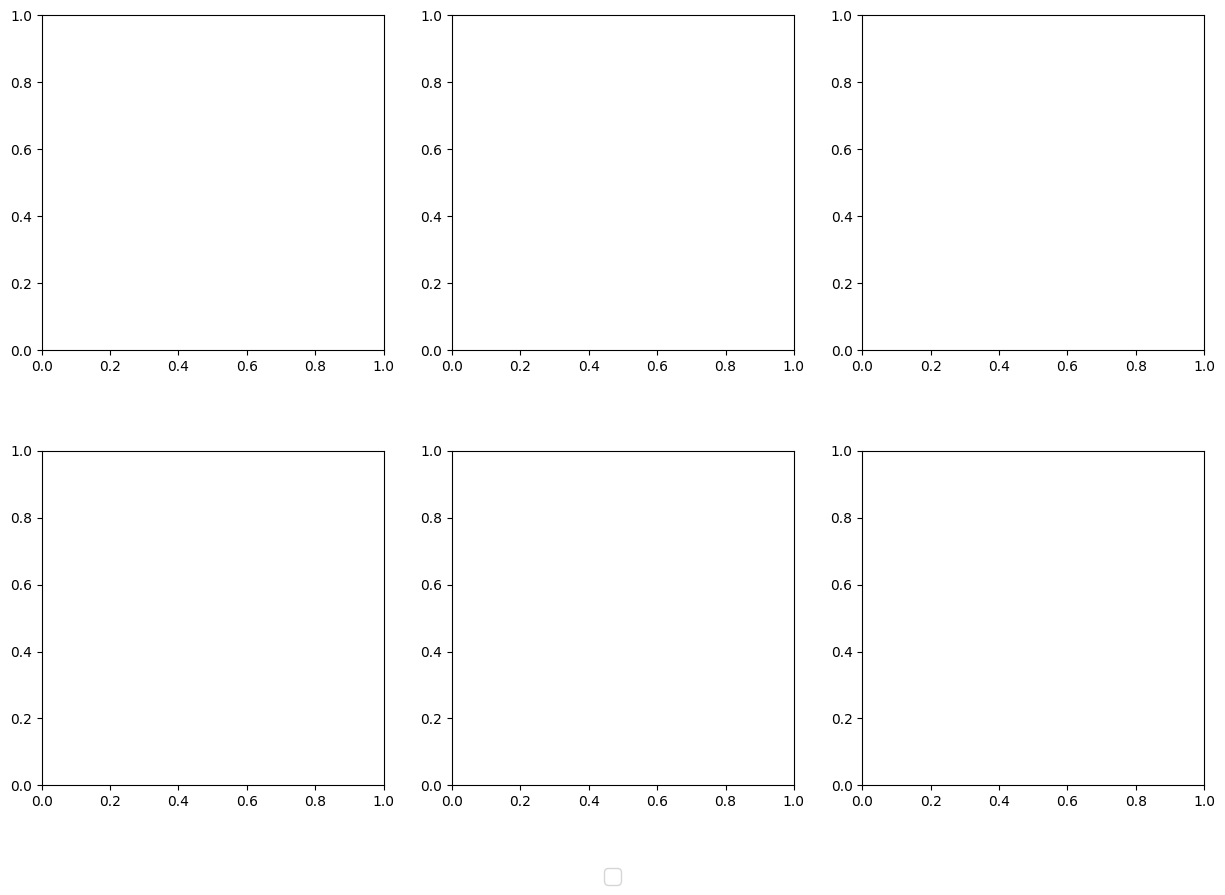

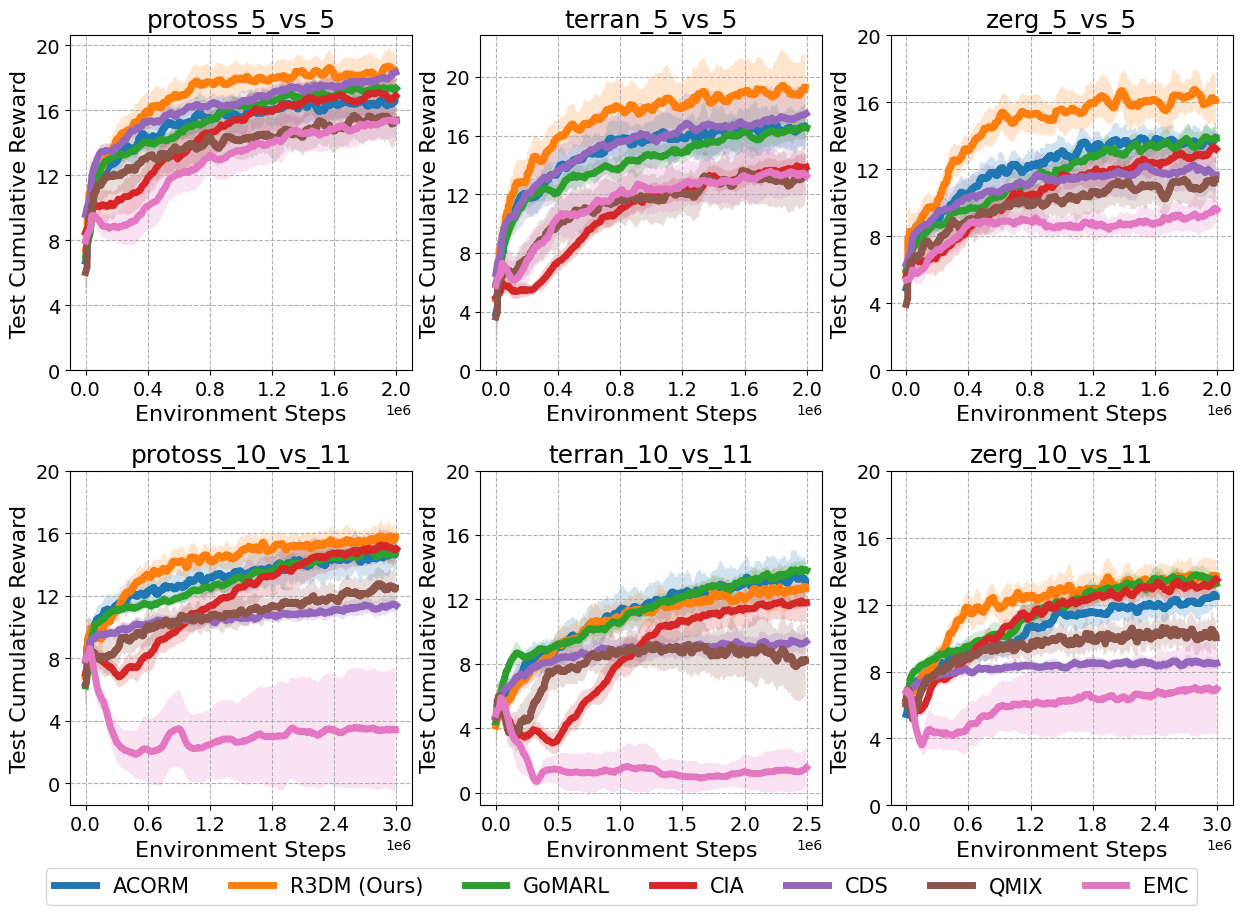

In [24]:
# Plot the results for each environment, all agents for one environment in one plot
if not os.path.exists('plots'):
    os.makedirs('plots')
agent_order = ['ACORM', 'R3DM', 'GoMARL', 'CIA', 'CDS', 'QMIX', 'EMC']

# Make a 3x2 plot of the results

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))
axes2 = axes2.flatten()

smac_env = ['5m_vs_6m', 'MMM2', '3s5z_vs_3s6z', '27m_vs_30m', '6h_vs_8z', 'Corridor','2c_vs_64zg']
smac_v2_enc = ['protoss_5_vs_5', 'terran_5_vs_5', 'zerg_5_vs_5', 'protoss_10_vs_11', 'terran_10_vs_11', 'zerg_10_vs_11']
n_rows = 5
n_cols = 5
for _, env in enumerate(averaged_results):
   
    if env in smac_env:
        idx = smac_env.index(env)
        ax = axes[idx]
    else:
        idx = smac_v2_enc.index(env)
        ax = axes2[idx]
    for agent in agent_order:
        if agent not in averaged_results[env]:
            continue
        results = averaged_results[env][agent]
        results = results[results['Step'] <= max_steps[env]]
        if agent == 'R3DM':
            label = agent + ' (Ours)'
        else:
            label = agent
        ax.plot(results['Step'], results['Value'], label=label, linewidth=5 )
        ax.fill_between(results['Step'], 
                        results['Value'] - 0.75 * results['std_dev'], 
                        results['Value'] + 0.75 * results['std_dev'], 
                        alpha=0.2)
    ax.set_title(env, fontsize=18)  # Larger title font
    ax.set_xlabel('Environment Steps', fontsize=16)  # Larger axis labels
    if 'reward' in results_directory:
        ax.set_ylabel('Test Cumulative Reward', fontsize=16)
    else:
        ax.set_ylabel('Test Win Rate', fontsize=16)
    #ax.tick_params(axis='both', which='major', labelsize=12)  # Larger 
    
    x_ticks = [s for s in range(0, max_steps[env] + max_steps[env]//5, max_steps[env]//5)]
    ax.set_xticks(x_ticks)   # Five vertical gridlines
    if 'reward' in results_directory:
        ax.set_yticks([0.0, 4.0, 8.0, 12.0, 16.0, 20.0])  
    else:
        ax.set_yticks([0.0, 0.20, 0.40, 0.60, 0.80, 1.0])   # Five horizontal gridlines
    #ax.set_yticks([0.0, 4.0, 8.0, 12.0, 16.0, 20.0])   # Five horizontal gridlines
    ax.grid(visible=True, linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=14) 
fig.subplots_adjust(hspace=0.3) 
fig2.subplots_adjust(hspace=0.3)    
# Add a common legen
if 'reward' in results_directory:
    tag = 'reward'
else:
    tag = ''
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(agent_order), fontsize=15)
plt.tight_layout(rect=[0, 0, 1, -1.70])
fig.savefig('plots/combined_plot{}.png'.format(tag),     bbox_inches='tight',)
fig.show()

handles, labels = axes2[3].get_legend_handles_labels()
fig2.legend(handles, labels, loc='lower center', ncol=len(agent_order), fontsize=15)
plt.tight_layout(rect=[0, 0, 1, -1.70])

fig2.savefig('plots/combined_plot2{}.png'.format(tag),     bbox_inches='tight',)
fig2.show()


# Ablation Plots


In [25]:
# Plots

#results_directory = 'exp_results_wm/'
results_directory = 'exp_results_ablation/'
ablations = ['contrastive','rewardhorizon','roles']
# Load the results
# Folder structure "env_name/run-agent_name_seed**.csv"
# For each environment and agent load all corresponding csv

envs = os.listdir(results_directory)
max_steps = {
    '3s5z_vs_3s6z': 3000000,
}
env = '3s5z_vs_3s6z'

results_envs = OrderedDict()
for ablation in ablations:
    results_envs[ablation] = OrderedDict()
    env_dir = os.path.join(results_directory, '3s5z_vs_3s6z', ablation)
    results = os.listdir(env_dir)

    for result in results:
        if result == '.DS_Store' or result == 'legacy':
            continue
            
        if result.split('-')[0] == 'run':
            run_name = result.split('-')[1]
        else:
            run_name = result.split('-')[0]
        
        agent = run_name.split('_')[0]

                
        if agent == 'ACORMWM':
            agent ='R3DM'
        elif 'Ro' in agent:
            agent = 'R3DM' + ' (Roles ' + str(int(agent.split('Ro')[1])) + ')'
        elif 'Im' in agent:
            agent = 'R3DM' + ' (Reward Imagination ' + str(int(agent.split('Im')[1])) +')'
        elif 'NoCL' in agent:
            agent = 'R3DM' + ' (No Contrastive Learning)'

            
        csv_results = pd.read_csv(results_directory + env + '/' + ablation+'/'+ result)
        if agent not in results_envs[ablation]:    
            results_envs[ablation][agent] = [csv_results]
        else:
            results_envs[ablation][agent].append(csv_results)


In [26]:
# Average the 'value' column per timestep if there are multiple runs

averaged_results = OrderedDict()

for env in results_envs:
    averaged_results[env] = OrderedDict()
    for agent in results_envs[env]:
        results = results_envs[env][agent]
        if 'ACORM' in agent or 'R3DM' in agent:
            # For each step average the all available values, ignore empty entries and dont fill
            print('Computing statistics for ' + env + ' ' + agent)
            stats = compute_statistics(results[0], every=25)
            window_size = 7
            avg_results = pd.DataFrame.from_dict(stats, orient='index')
            avg_results['Value'] = avg_results['Value'].rolling(window=window_size, min_periods=1, center=True).mean()
            avg_results['std_dev'] = avg_results['std_dev'].rolling(window=window_size, min_periods=1, center=True).mean()
            averaged_results[env][agent] = avg_results
                
        # else:
        #     if len(results) > 1:
        #         # Average the 'value' column
        #         avg_results = results[0]
                
        #         for i in range(1, len(results)):
        #             avg_results['Value'] += results[i]['Value']
        #             avg_results['Step'] += results[i]['Step']
        #         avg_results['Value'] /= len(results)
        #         avg_results['Step'] /= len(results) 
                
        #         # Compute Standard Deviation
        #         std_dev = np.zeros(len(avg_results['Value']))
        #         for i in range(len(results)):
        #             std_dev += (results[i]['Value'] - avg_results['Value'])**2
        #         std_dev = np.sqrt(std_dev/len(results))
        #         avg_results['std_dev'] = std_dev
        #         # Apply rolling window mean to smoothen results
        #         window_size = 7
        #         avg_results['Value'] = avg_results['Value'].rolling(window=window_size, min_periods=1, center=True).mean()
        #         avg_results['std_dev'] = avg_results['std_dev'].rolling(window=window_size, min_periods=1, center=True).mean()

        #         averaged_results[env][agent] = avg_results
                
        #     else:
        #         avg_results = results[0]
        #         # Compute Standard Deviation 
        #         std_dev = np.zeros(len(results[0]['Value']))
        #         avg_results['std_dev'] = std_dev
        #         averaged_results[env][agent] = avg_results

Computing statistics for contrastive R3DM
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[

In [27]:

averaged_results['roles']['R3DM (Roles 1)'].keys()

KeyError: 'R3DM (Roles 1)'

<Figure size 640x480 with 0 Axes>

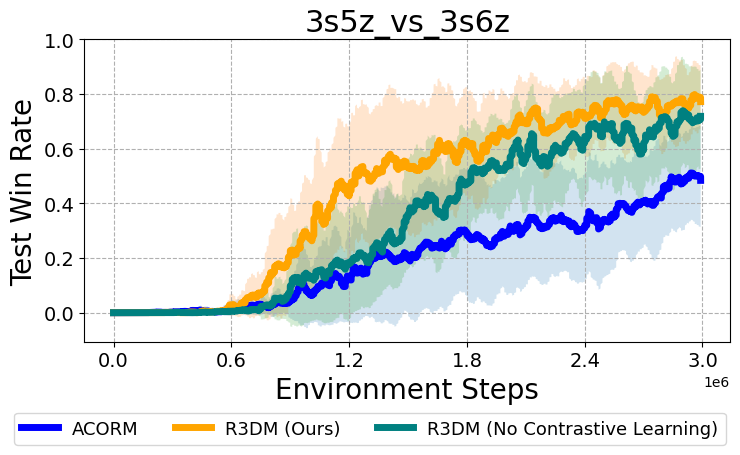

<Figure size 640x480 with 0 Axes>

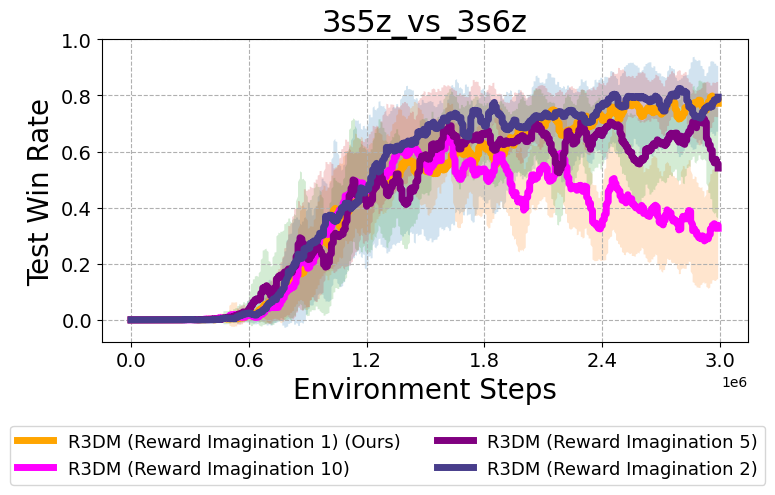

<Figure size 640x480 with 0 Axes>

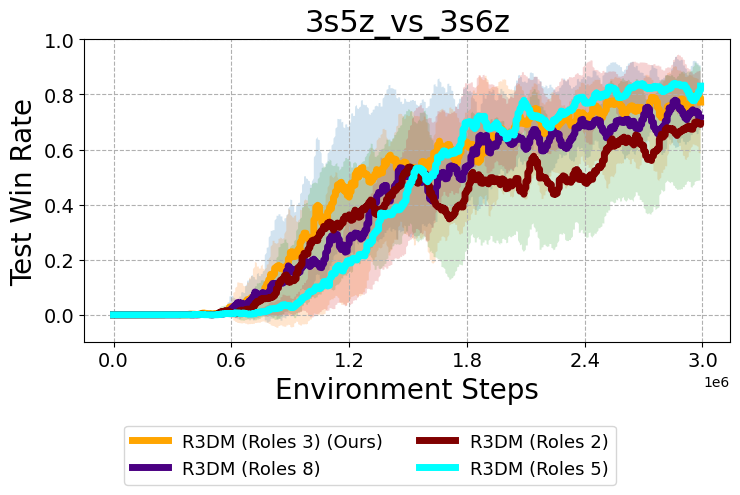

In [30]:
# Plot the results for each environment, all agents for one environment in one plot
if not os.path.exists('plots'):
    os.makedirs('plots')


# Make a 3x2 plot of the results




ablations = ['contrastive','rewardhorizon','roles']
# smac_env = ['5m_vs_6m', 'MMM2', '3s5z_vs_3s6z', '27m_vs_30m', '6h_vs_8z', 'Corridor','2c_vs_64zg']
# smac_v2_enc = ['protoss_5_vs_5', 'terran_5_vs_5', 'zerg_5_vs_5', 'protoss_10_vs_11', 'terran_10_vs_11', 'zerg_10_vs_11']
n_rows = 5
n_cols = 5
max_steps = {
    '3s5z_vs_3s6z': 3000000,
}
env = '3s5z_vs_3s6z'
colormap = {'ACORM': 'blue', 'R3DM': 'orange'}
colors = ['teal', 'magenta', 'purple', 'darkslateblue', 'indigo', 'maroon', 'cyan']


for _, ablation in enumerate(averaged_results):
    plt.figure()
    fig, axes = plt.subplots(1, 1, figsize=(7.5, 5))
    if ablation in ablations:
        idx = ablations.index(ablation)
        ax = axes
    agent_order = ['ACORM', 'R3DM', 'R3DM (Roles 3)', 'R3DM (Reward Imagination 1)']
    keys =  averaged_results[ablation].keys()
    for key in keys:
        agent_order.append(key) if key not in agent_order else None
        
    for agent in agent_order:
        if agent not in averaged_results[ablation]:
            continue
        results = averaged_results[ablation][agent]
        results = results[results['Step'] <= max_steps[env]]
        if agent == 'R3DM' or agent == 'R3DM (Roles 3)' or agent == 'R3DM (Reward Imagination 1)':
            label = agent + ' (Ours)'
            color = colormap['R3DM']
        else:
            label = agent
            if agent in colormap:
                color = colormap[agent]
            else:
                color = colors.pop(0)
                colormap[agent] = color
        ax.plot(results['Step'], results['Value'], label=label, linewidth=5, c=color) 
        ax.fill_between(results['Step'], 
                        results['Value'] - 0.75 * results['std_dev'], 
                        results['Value'] + 0.75 * results['std_dev'], 
                        alpha=0.2)
    ax.set_title(env, fontsize=22)  # Larger title font
    ax.set_xlabel('Environment Steps', fontsize=20)  # Larger axis labels
    if 'reward' in results_directory:
        ax.set_ylabel('Test Returns', fontsize=20)
    else:
        ax.set_ylabel('Test Win Rate', fontsize=20)
    #ax.tick_params(axis='both', which='major', labelsize=12)  # Larger 
    
    x_ticks = [s for s in range(0, max_steps[env] + max_steps[env]//5, max_steps[env]//5)]
    ax.set_xticks(x_ticks)   # Five vertical gridlines
    if 'reward' in results_directory:
        ax.set_yticks([0.0, 4.0, 8.0, 12.0, 16.0, 20.0])  
    else:
        ax.set_yticks([0.0, 0.20, 0.40, 0.60, 0.80, 1.0])   # Five horizontal gridlines
    #ax.set_yticks([0.0, 4.0, 8.0, 12.0, 16.0, 20.0])   # Five horizontal gridlines
    ax.grid(visible=True, linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=14) 
    fig.subplots_adjust(hspace=0.3)    
    # Add a common legen
    if 'reward' in results_directory:
        tag = 'reward'
    else:
        tag = ''
    handles, labels = axes.get_legend_handles_labels()
    if ablation == 'rewardhorizon' or ablation == 'roles':
        fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=13,  bbox_to_anchor=(0.5, -0.15))
        plt.tight_layout(rect=[0, 0, 1.0, 0.85])
    else:
        fig.legend(handles, labels, loc='lower center', ncol=len(agent_order), fontsize=13,  bbox_to_anchor=(0.5, -0.07))
        plt.tight_layout(rect=[0, 0, 1.0, 0.85])
    fig.savefig('plots/combined_plot_alation{}.png'.format(tag),     bbox_inches='tight',)
    fig.show()



In [45]:
print(colormap)

{'ACORM': 'blue', 'R3DM': 'orange', 'R3DM (No Contrastive Learning)': 'teal', 'R3DM (Reward Imagination 10)': 'magenta', 'R3DM (Reward Imagination 5)': 'purple', 'R3DM (Reward Imagination 2)': 'darkslateblue', 'R3DM (Roles 8)': 'indigo', 'R3DM (Roles 2)': 'maroon', 'R3DM (Roles 5)': 'lightsalmon'}


In [16]:
# Get the role embeddings and plot a tsne of the embeddings, lets create a gif of the embeddings changing over time


